In [34]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import itertools

In [36]:
#Dates for which we will predict stock prices - Option Expiry Dates, which end on Friday of any week
today = datetime.date.today()
start_date = datetime.date.today()+ datetime.timedelta( (4-today.weekday()) % 7 )
end_date = datetime.date.today() + datetime.timedelta(days=28)
delta = datetime.timedelta(days=7)

option_dates = []

while start_date <= end_date:
    o_d = start_date.strftime("%Y-%m-%d")
    option_dates.append(o_d)
    start_date += delta

option_dates

['2020-08-21', '2020-08-28', '2020-09-04', '2020-09-11']

In [180]:
Company_Names = ["AMZN", "MSFT","AAPL", "TSLA", "NFLX","FB","V","NVDA","GOOG","BA","INTC",'AMD',"F","GE","AAL",\
                 "DIS", "DAL", "CCL", "SNAP","UAL","BABA","UBER","TWTR","SBUX","SPY","QQQ","BYND","SQ","PENN",\
                "XOM", "SHOP","ATVI","WMT","MRNA","JPM","GS","CITI","SNE","MGM"]
np.shape(Company_Names)

(39,)

In [59]:
OUTPUT_FOLDER = "Option_Weekly_csv"
import os
try:
    os.mkdir(OUTPUT_FOLDER)
except FileExistsError:
    pass

In [60]:
test_op = option_prediction(Company_Names=Company_Names, option_dates=option_dates, output_folder=OUTPUT_FOLDER)

[*********************100%***********************]  1 of 1 completed


/Users/xpatricklorenzx/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/xpatricklorenzx/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Exported: Option_Weekly_csv/2020_08_20/Option_Weekly_2020_08_20.csv


[-3.718692090404929, 1.8487488049932799, -1.3868350418325168, -0.5405660324113506]
Exported: Option_Weekly_csv/2020_08_20/Option_Weekly_Plot_2020_08_20.pdf


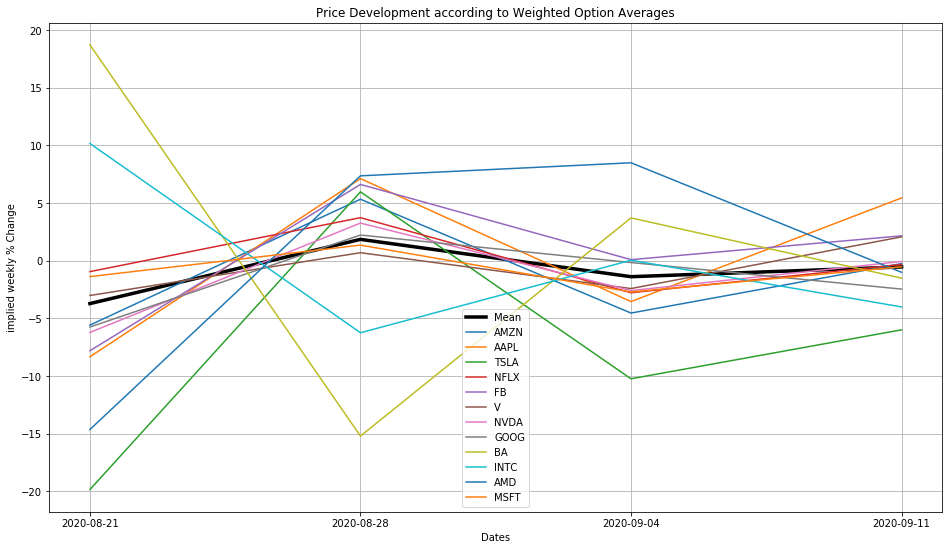

In [92]:
plot_option_prediction(option_prediction=test_op, Company_Names=Company_Names, 
                       option_dates=option_dates, output_folder=OUTPUT_FOLDER)

In [58]:
def option_prediction (Company_Names, option_dates, output_folder=OUTPUT_FOLDER, export_table=True):
    """
    Inputs:
        - Company_Names as ticker list
        - option_dates as date list in format %Y-%M-D
    Returns:
        - DataFrame
        
    """
    #Loop to calculate Weighted Average Strike Price (predicted Price) between Put & Call Options
    ticker_t_p_list = []
    price_change_list = []
    Calls_WOI_list = []
    Puts_WOI_list = []
    CP_WMid_list = []

    for x in Company_Names:
        #To get Options Data of Ticker list
        ticker = yf.Ticker(x)

        #To get Price Data of Ticker list
        tickerp = yf.download(x, start= datetime.date.today() - datetime.timedelta(days=2))
        ticker_p = tickerp['Close']
        ticker_t_p = ticker_p[-1]
        ticker_t_p_list.append(ticker_t_p)
        ticker_ytd_p = ticker_p[-2]
        price_change = (ticker_t_p -ticker_ytd_p)/ ticker_ytd_p *100
        price_change = round(price_change,4)
        price_change_list.append(price_change)

        for y in option_dates:
            #To adjust the Options Dataframe for calls and puts
            tickeroptioninfo = ticker.option_chain(y)
            calls_strikes_OI = tickeroptioninfo.calls[["contractSymbol","strike","openInterest"]]
            calls_strikes_OI = calls_strikes_OI.replace(0, np.nan)
            calls_strikes_OI_dropna = calls_strikes_OI.dropna(how='any', axis=0)
            calls_strikes_OI_dropna_droph = calls_strikes_OI_dropna.drop(calls_strikes_OI_dropna['openInterest'].idxmax())
            calls_strikes_OI = calls_strikes_OI_dropna_droph["strike"]
            calls_openInterest = calls_strikes_OI_dropna_droph["openInterest"]

            puts_strikes_OI = tickeroptioninfo.puts[["strike","openInterest"]]
            puts_strikes_OI = puts_strikes_OI.replace(0, np.nan)
            puts_strikes_OI_dropna = puts_strikes_OI.dropna(how='any', axis=0)
            puts_strikes_OI_dropna_droph = puts_strikes_OI_dropna.drop(puts_strikes_OI_dropna['openInterest'].idxmax())
            puts_strikes_OI = puts_strikes_OI_dropna_droph["strike"]
            puts_openInterest = puts_strikes_OI_dropna_droph["openInterest"]

            #Throwing out the tails of the Open Interest distribution to not get a distorted calculation
            #(basically getting rid of the largest OI and all those that are smaller than 5% of the largest)
            Top_Call_OI = calls_strikes_OI_dropna_droph['openInterest'].max()
            Top_Put_OI = puts_strikes_OI_dropna_droph['openInterest'].max()
            Top_CP_OI = [Top_Call_OI, Top_Put_OI]
            Top_Limit_OI = max(Top_CP_OI)

            limit = (Top_Limit_OI / 20)
            bigP_OI = puts_strikes_OI_dropna_droph[puts_strikes_OI_dropna_droph['openInterest'] > limit] 
            bigC_OI = calls_strikes_OI_dropna_droph[calls_strikes_OI_dropna_droph['openInterest'] > limit]

            mylist = []

            for c_n in Company_Names:
                df = (c_n,) * np.shape(option_dates)[0]
                mylist.append(df)

            C_N_df = list(itertools.chain(*mylist)) 

            option_dates_df = option_dates * np.shape(Company_Names)[0]

            Calls_OI_PCT=[]

            #Calculating the Weighted OI Average for puts and Calls
            for z in bigC_OI['openInterest']:
                oi = z / np.sum(bigC_OI['openInterest'])
                Calls_OI_PCT.append(oi)

            bigC_OI['OI_PCT'] = Calls_OI_PCT
            bigC_WOI = bigC_OI[['strike','openInterest', 'OI_PCT']]

            bigC_WOI['WOI'] = bigC_WOI['strike'] * bigC_WOI['OI_PCT']
            Calls_WOI = np.sum(bigC_WOI['WOI'])
            Calls_WOI_list.append(Calls_WOI)

            Puts_OI_PCT=[]

            for a in bigP_OI['openInterest']:
                oi = a / np.sum(bigP_OI['openInterest'])
                Puts_OI_PCT.append(oi)

            bigP_OI['OI_PCT'] = Puts_OI_PCT
            bigP_WOI = bigP_OI[['strike','openInterest', 'OI_PCT']]

            bigP_WOI['WOI'] = bigP_WOI['strike'] * bigP_WOI['OI_PCT']
            Puts_WOI = np.sum(bigP_WOI['WOI'])
            Puts_WOI_list.append(Puts_WOI)

            #Calculating the Weighted Midpoint and implied difference to today
            Sum_OI = np.shape(bigP_WOI)[0] + np.shape(bigC_WOI)[0]
            CP_WMid = (Calls_WOI*(np.shape(bigC_WOI)[0]/Sum_OI) + Puts_WOI*(np.shape(bigP_WOI)[0]/Sum_OI))
            CP_WMid_list.append(CP_WMid)

            for b in ticker_t_p_list:
                CP_WMid_Price_Diff = CP_WMid - b

                CP_WMid_Price_Diff_Pct = CP_WMid_Price_Diff / b *100
    #Set up DF-shape as function of Companies and Expiry Dates
    myprices = []

    for x in ticker_t_p_list:
        dfprices = (x,) * np.shape(option_dates)[0]
        myprices.append(dfprices)

    Prices_df = list(itertools.chain(*myprices))

    x_dates = []
    for x in option_dates_df:
        x_date = datetime.datetime.strptime(x, "%Y-%m-%d")
        x_dates.append(x_date)

    Today = [None] * (np.shape(Company_Names)[0]*np.shape(option_dates)[0])

    Today = [datetime.datetime.today() if x==None else x for x in Today]

    Days_to_Exp = [a - b for a, b in zip(x_dates, Today)]
    #Weekly Price Changes from TODAY DF
    Option_Analysis_T0 = pd.DataFrame({'Tickers': C_N_df, "Todays Price": Prices_df,'Option Exp Date': option_dates_df, \
                                    "Days_to_Exp": Days_to_Exp,"Calls_WOI": Calls_WOI_list, \
                                    "Puts_WOI": Puts_WOI_list, "Predicted_Opt_Price":CP_WMid_list})
    Option_Analysis_T0["implied Change from T0"] = Option_Analysis_T0["Predicted_Opt_Price"] - Option_Analysis_T0["Todays Price"] 
    Option_Analysis_T0["implied %Change from T0"] = (Option_Analysis_T0["implied Change from T0"] / \
                                                  Option_Analysis_T0["Todays Price"])*100
    #Inter-Weekly Changes DF - X-train/test for TF
    Pct_Change_T1_df=[]
    Price_diff_T1_l_df = []

    for x in Company_Names:
        Option_Analysis_T1 = Option_Analysis_T0.loc[lambda Option_Analysis_T0: Option_Analysis_T0['Tickers']== x, :]
        Option_Analysis_T1_reset = Option_Analysis_T1.reset_index(drop=True)
        Price_diff_T1 = np.diff(Option_Analysis_T1_reset["implied Change from T0"])
        Price_diff_T1_l = list(Price_diff_T1)

        Pct_Change_T1 = list(Price_diff_T1_l / Option_Analysis_T1_reset["Predicted_Opt_Price"][:3]*100)
        Pct_Change_initial = Option_Analysis_T1_reset["implied %Change from T0"][0]
        Price_Change_initial = Option_Analysis_T1_reset["implied Change from T0"][0]

        Pct_Change_T1.insert(0,Pct_Change_initial)
        Price_diff_T1_l.insert(0, Price_Change_initial)

        for y in Pct_Change_T1:
            Pct_Change_T1_df.append(y)

        for z in Price_diff_T1_l:
            Price_diff_T1_l_df.append(z)

    Option_Analysis_Weekly = pd.DataFrame({'Tickers': C_N_df, "Todays Price": Prices_df,\
                                           'Option Exp Date': option_dates_df, \
                                           "Days_to_Exp": Days_to_Exp,"Calls_WOI": Calls_WOI_list, \
                                           "Puts_WOI": Puts_WOI_list, "Predicted_Opt_Price":CP_WMid_list,\
                                           "implied Change to prior week":Price_diff_T1_l_df,\
                                           "implied %Change to prior week": Pct_Change_T1_df})

    today_str = str(today).replace("-", "_")
    try:
        folder = os.path.join(output_folder, today_str)
        os.mkdir(folder)
    except FileExistsError:
        pass
    
    table_name = os.path.join(folder, "Option_Weekly_{}.csv".format(today_str))
    if export_table:
        Option_Analysis_Weekly.to_csv(table_name)
        print("Exported: {}".format(table_name))
    return Option_Analysis_Weekly

In [177]:
def plot_option_prediction(option_prediction, Company_Names, option_dates, output_folder=OUTPUT_FOLDER, export_figure=True):
    #Plot the price changes and mean as implied in the Options Market

    Option_Analysis_T2_mean_plot = []

    for y in option_dates:
        Option_Analysis_T2 = option_prediction.loc[lambda option_prediction: \
                                                   option_prediction['Option Exp Date']== y, :]
        Option_Analysis_T2_reset = Option_Analysis_T2.reset_index(drop=True)
        Option_Analysis_T2_mean = np.sum(Option_Analysis_T2_reset['implied %Change to prior week']) / \
        np.shape(Option_Analysis_T2_reset["implied %Change to prior week"])[0]

        Option_Analysis_T2_mean_plot.append(Option_Analysis_T2_mean)

    fig = plt.figure(figsize=(16,9))
    plt.plot(Option_Analysis_Weekly["Days_to_Exp"], Option_Analysis_T2_mean_plot, c="k", label="Mean", linewidth=3.5)
    plt.xlabel("Dates")
    plt.ylabel("implied weekly % Change")
    plt.title("Price Development according to Weighted Option Averages")

    for x in Company_Names:
        Option_Analysis_T3 = option_prediction.loc[lambda option_prediction: \
                                                   option_prediction['Tickers']== x, :]
        Option_Analysis_T3_reset = Option_Analysis_T3.reset_index(drop=True)
        plt.plot(Option_Analysis_Weekly["Days_to_Exp"], Option_Analysis_T3_reset["implied %Change to prior week"],\
                 label=x)
        
    plt.grid()
    plt.legend()

    print(Option_Analysis_T2_mean_plot)
    
    today_str = str(today).replace("-", "_")
    
    try:
        folder = os.path.join(output_folder, today_str)
        os.mkdir(folder)
    except FileExistsError:
        pass

    fig_name = os.path.join(folder, "Option_Weekly_Plot_{}.pdf".format(today_str))
    if export_figure:
        plt.savefig(fig_name)
        print("Exported: {}".format(fig_name))

In [39]:
#Set up DF-shape as function of Companies and Expiry Dates
myprices = []

for x in ticker_t_p_list:
    dfprices = (x,) * np.shape(option_dates)[0]
    myprices.append(dfprices)

Prices_df = list(itertools.chain(*myprices))

x_dates = []
for x in option_dates_df:
    x_date = datetime.datetime.strptime(x, "%Y-%m-%d")
    x_dates.append(x_date)
    
Today = [None] * (np.shape(Company_Names)[0]*np.shape(option_dates)[0])

Today = [datetime.datetime.today() if x==None else x for x in Today]

Days_to_Exp = [a - b for a, b in zip(x_dates, Today)]

In [108]:
#DF to show the change that is predicted in the Options market by Expiry Date
#Weekly Price Changes from TODAY DF
Option_Analysis_T0 = pd.DataFrame({'Tickers': C_N_df, "Todays Price": Prices_df,'Option Exp Date': option_dates_df, \
                                "Days_to_Exp": Days_to_Exp,"Calls_WOI": Calls_WOI_list, \
                                "Puts_WOI": Puts_WOI_list, "Predicted_Opt_Price":CP_WMid_list})
Option_Analysis_T0["implied Change from T0"] = Option_Analysis_T0["Predicted_Opt_Price"] - Option_Analysis_T0["Todays Price"] 
Option_Analysis_T0["implied %Change from T0"] = (Option_Analysis_T0["implied Change from T0"] / \
                                              Option_Analysis_T0["Todays Price"])*100

#Option_Analysis_T0


In [54]:
#Inter-Weekly Changes DF - X-train/test for TF

Pct_Change_T1_df=[]
Price_diff_T1_l_df = []

for x in Company_Names:
    Option_Analysis_T1 = Option_Analysis_T0.loc[lambda Option_Analysis_T0: Option_Analysis_T0['Tickers']== x, :]
    Option_Analysis_T1_reset = Option_Analysis_T1.reset_index(drop=True)
    Price_diff_T1 = np.diff(Option_Analysis_T1_reset["implied Change from T0"])
    Price_diff_T1_l = list(Price_diff_T1)
    
    Pct_Change_T1 = list(Price_diff_T1_l / Option_Analysis_T1_reset["Predicted_Opt_Price"][:3]*100)
    Pct_Change_initial = Option_Analysis_T1_reset["implied %Change from T0"][0]
    Price_Change_initial = Option_Analysis_T1_reset["implied Change from T0"][0]
    
    Pct_Change_T1.insert(0,Pct_Change_initial)
    Price_diff_T1_l.insert(0, Price_Change_initial)

    for y in Pct_Change_T1:
        Pct_Change_T1_df.append(y)
    
    for z in Price_diff_T1_l:
        Price_diff_T1_l_df.append(z)
        
Option_Analysis_Weekly = pd.DataFrame({'Tickers': C_N_df, "Todays Price": Prices_df,\
                                       'Option Exp Date': option_dates_df, \
                                       "Days_to_Exp": Days_to_Exp,"Calls_WOI": Calls_WOI_list, \
                                       "Puts_WOI": Puts_WOI_list, "Predicted_Opt_Price":CP_WMid_list,\
                                       "implied Change to prior week":Price_diff_T1_l_df,\
                                       "implied %Change to prior week": Pct_Change_T1_df})

import os
try:
    folder = "Option_Weekly_csv"
    os.mkdir(folder)
except FileExistsError:
    pass
    
table_name = os.path.join(folder, "Option_Weekly_{}.csv".format(str(today).replace("-", "_")))
Option_Analysis_Weekly.to_csv(table_name)
Option_Analysis_Weekly

,Tickers,Todays Price,Option Exp Date,Days_to_Exp,Calls_WOI,Puts_WOI,Predicted_Opt_Price,implied Change to prior week,implied %Change to prior week
0,AMZN,3295.294922,2020-08-21,0 days 03:36:39.078026,3387.735888,2856.325211,3117.674724,-177.620198,-5.390115
1,AMZN,3295.294922,2020-08-28,7 days 03:36:39.078014,3523.230431,3048.392818,3283.782404,166.107680,5.327935
2,AMZN,3295.294922,2020-09-04,14 days 03:36:39.078011,3331.200410,2977.601845,3134.756763,-149.025640,-4.538231
3,AMZN,3295.294922,2020-09-11,21 days 03:36:39.078009,3329.393994,2989.268540,3126.876548,-7.880215,-0.251382
4,AAPL,469.670013,2020-08-21,0 days 03:36:39.078006,485.685429,387.298546,431.026049,-38.643964,-8.227897
5,AAPL,469.670013,2020-08-28,7 days 03:36:39.078003,483.979710,424.903096,461.686648,30.660598,7.113398
6,AAPL,469.670013,2020-09-04,14 days 03:36:39.078000,482.980053,402.667169,445.333389,-16.353259,-3.542069
7,AAPL,469.670013,2020-09-11,21 days 03:36:39.077998,505.191772,416.881430,469.557775,24.224386,5.439607
8,TSLA,1992.599976,2020-08-21,0 days 03:36:39.077995,2078.144371,1208.048530,1614.093256,-378.506720,-18.995620
9,TSLA,1992.599976,2020-08-28,7 days 03:36:39.077992,2059.987506,1360.888190,1710.437848,96.344592,5.968961


In [ ]:
Option_Analysis_T2_mean_plot = []

for y in option_dates:
    Option_Analysis_T2 = Option_Analysis_Weekly.loc[lambda Option_Analysis_Weekly: \
                                                Option_Analysis_Weekly['Option Exp Date']== y, :]
    Option_Analysis_T2_reset = Option_Analysis_T2.reset_index(drop=True)
    Option_Analysis_T2_mean = np.sum(Option_Analysis_T2_reset['implied %Change to prior week']) / \
    np.shape(Option_Analysis_T2_reset["implied %Change to prior week"])[0]

    Option_Analysis_T2_mean_plot.append(Option_Analysis_T2_mean)

plt.figure(figsize=(16,9))
plt.plot(option_dates,Option_Analysis_T2_mean_plot,c="k", label="Mean", linewidth=3.5)
plt.xlabel("Dates")
plt.ylabel("implied weekly % Change")
plt.title("Price Development according to Weighted Option Averages")
plt.legend()

for x in Company_Names:
    Option_Analysis_T3 = Option_Analysis_Weekly.loc[lambda Option_Analysis_Weekly: \
                                                Option_Analysis_Weekly['Tickers']== x, :]
    Option_Analysis_T3_reset = Option_Analysis_T3.reset_index(drop=True)

    plt.plot(option_dates,Option_Analysis_T3_reset["implied %Change to prior week"], label = x)
    plt.xlabel("Dates")
    plt.ylabel("implied % Change")
    plt.title("Price Development according to Weighted Option Averages")
    plt.grid(True)
    plt.legend()

print(Option_Analysis_T2_mean_plot)

In [158]:
C_N_marketCap = []

for x in Option_Analysis_Weekly["Tickers"]:
    ticker = yf.Ticker(x)
    info_dic = ticker.info
    var1 = info_dic['marketCap']
    C_N_marketCap.append(int(var1))
    
marketCap_df = pd.DataFrame({"Tickers": C_N_df, "marketCap": C_N_marketCap})
marketCap_df['MC_billions'] = marketCap_df["marketCap"]/1000000000

df_ratio = pd.merge(Option_Analysis_Weekly, marketCap_df, on='Tickers', how='outer')
df_ratio_cut = df_ratio[["Tickers","MC_billions"]]

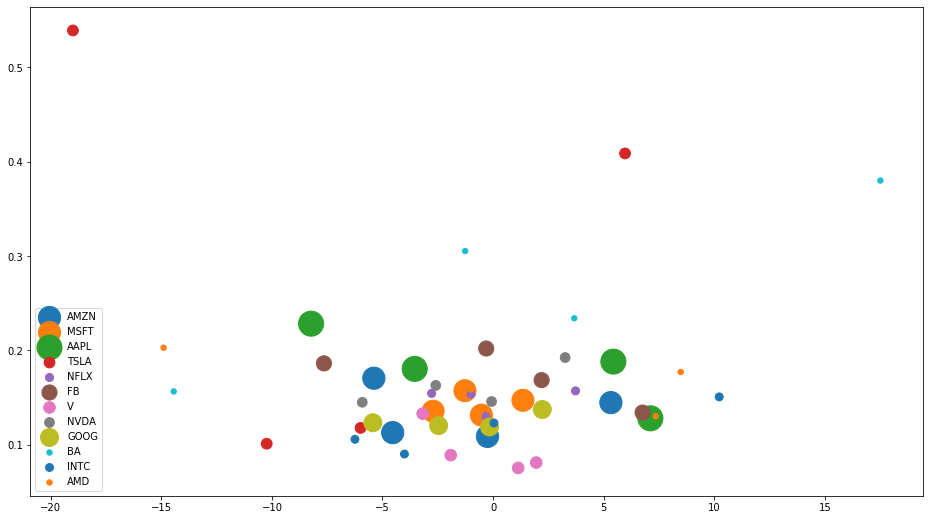

In [176]:
#Further Data Analysis on (1) DataFrame/current and (1) CSV/historical
    
Option_Analysis_Weekly["CP-Diff"] = Option_Analysis_Weekly["Calls_WOI"] - Option_Analysis_Weekly["Puts_WOI"]
Option_Analysis_Weekly[["Calls_WOI","Puts_WOI","Predicted_Opt_Price","CP-Diff"]]
Option_Analysis_Weekly["CP Spread/Price Ratio"] = Option_Analysis_Weekly["CP-Diff"] / \
Option_Analysis_Weekly["Predicted_Opt_Price"]

Option_Analysis_Weekly[["CP Spread/Price Ratio","implied %Change to prior week"]]

Option_Analysis_Weekly_V2 = Option_Analysis_Weekly[["Tickers","implied %Change to prior week","CP Spread/Price Ratio"]]

plt.figure(figsize=(16,9))

for y in Company_Names:
    Option_Analysis_R2 = Option_Analysis_Weekly_V2.loc[lambda Option_Analysis_Weekly_V2: \
                                                       Option_Analysis_Weekly_V2['Tickers']== y, :]
    Option_Analysis_R2_reset = Option_Analysis_R2.reset_index(drop=True)
    df_ratio_cut_V2 = df_ratio_cut.loc[lambda df_ratio_cut: \
                                       df_ratio_cut['Tickers']== y, :]
    df_ratio_cut_V2_reset = df_ratio_cut_V2.reset_index(drop=True)
    plt.scatter(Option_Analysis_R2_reset['implied %Change to prior week'],\
                Option_Analysis_R2_reset['CP Spread/Price Ratio'],s=  df_ratio_cut_V2_reset["MC_billions"]*0.3,\
                label = Option_Analysis_R2_reset['Tickers'][0])
    plt.legend()


In [186]:
list(Option_Analysis_T3_reset["implied %Change to prior week"])[-1]

-0.5274900093423968

In [64]:
#3 X_test, X_train
#1. Price info of last week and currently
#2. Core info of option prediction over next weeks (FUTURE MARKET PREDICTION)
#3. MACD Gradient and Signal (HISTORICAL TECHNICAL PREDICTION)
#4. Cashflow, Growth, EBITDA, P/S, P/E (CURRENT FINANCIAL PREDICTION)

#1 Y_test, Y_train
#Price at expiry

#--> ACCURACY??

#Tensorflow analysis of 3 indicators and their signal strength on price

In [ ]:
def visualize_tree (classifier, X, y, boundaries=True, xlim=True, ylim=True):

    classifier.fit(X,y)
    
    if xlim is None:
        xlim =  (X[:,0].min() - 0.1, X[:,0].max() + 0.1)
    if ylim is None:
        ylim =  (X[:,1].min() - 0.1, X[:,1].max() + 0.1)
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
                        
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx,yy, Z, alpha = 0.2, cmap = 'jet')
    
    plt.scatter (X[:,0], X[:,1], c=y, cmap ='jet')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    def plot_boundaries(i, xlim, ylim):
        
        if i < 0:
            return
        
        tree = classifier.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                           [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                           [tree.threshold[i], xlim[1]], ylim)
            
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                           [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                           [tree.threshold[i], ylim[1]])
    
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

In [ ]:
clf = DecisionTreeClassifier(max_depth=1, random_state = 0)

strikes = ticker_puts['strike']
openInterest = ticker_puts['openInterest']



#my_X = np.array((ticker_puts['strike'], ticker_puts['openInterest']))
arg = np.where(ticker_puts['openInterest'] > x)[0]
my_X = np.array((ticker_puts['strike'][arg], ticker_puts['openInterest'][arg]))
my_Y = np.ones(my_X.shape[1])
arg_calls = np.where(ticker_calls['openInterest'] > x)[0]
my_X_calls = np.array((ticker_calls['strike'][arg_calls], ticker_calls['openInterest'][arg_calls]))
my_Y_calls  = np.zeros(my_X_calls.shape[1])
X = np.hstack((my_X, my_X_calls)).T
Y = np.hstack((my_Y, my_Y_calls))


visualize_tree(clf, X, Y, True, None, None)

In [69]:
#PLOT DIFFERENT EXPIRY DATE MOVES
#SNS PAIRPLOT PUTS PERCENT // CALLS PERCENT // Open Interest Puts / Calls
#options vol  vs realized vol??
#quadrants price indicators
# derivatives? Variance?
# open interest distribution?


In [ ]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')